In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

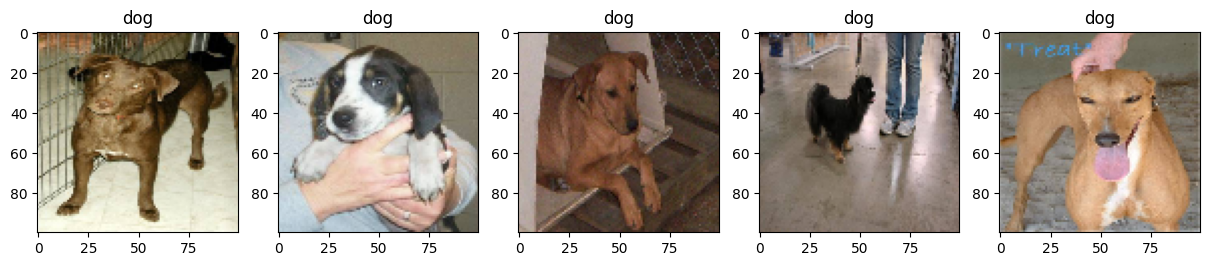

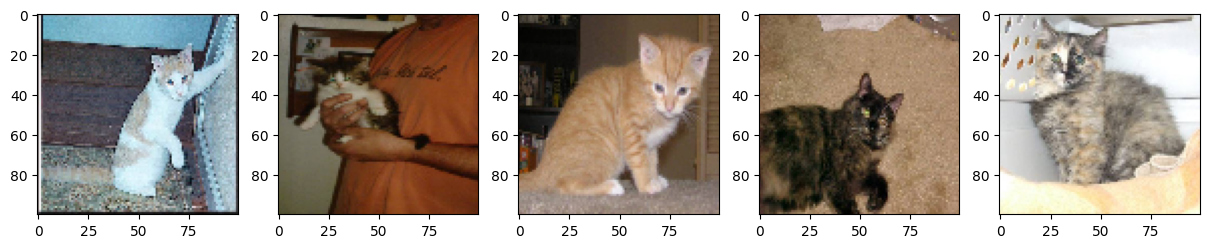

In [2]:
def process_files_with_labels(train_folder, labels_file=None):
    labels_df = pd.read_csv(labels_file)
    images = []
    labels = []
    for index, row in labels_df.iterrows():
        file_name = row['filename']
        label = row['label']
        file_path = os.path.join(train_folder, file_name)
        image = cv2.imread(file_path) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        resized_image = cv2.resize(image, (100, 100)) 
        images.append(resized_image)
        labels.append(label)
    return images, labels

def process_files_test(test_folder):
    images = []
    for dirpath, dirnames, filenames in os.walk(test_folder):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            resized_image = cv2.resize(image, (100, 100)) 
            images.append(resized_image)
    return images

def display_images(image_list, labels_list=None):
    rows, col = 1, 5
    fig = plt.figure(figsize=(15, 7))
    for index in range(min(len(image_list), 5)):
        ax = fig.add_subplot(rows, col, index + 1)
        image = image_list[index]
        image_pil = Image.fromarray(image)  
        ax.imshow(image_pil)  
        if labels_list is not None and index < len(labels_list):
            ax.set_title(str(labels_list[index])) 
        ax.axis('on')
    plt.show()

PATH = "C:\\work\\CNN cats and dogs\\"
TRAIN_PATH = PATH + "train\\"
TEST_PATH = PATH + "test\\"
CSV_PATH = PATH + "train_labels.csv"


train_images, train_labels = process_files_with_labels(TRAIN_PATH, CSV_PATH)
test_images = process_files_test(TEST_PATH)



display_images(train_images, train_labels)
display_images(test_images)

label2id = {"dog": 0, "cat": 1}
id2label = {0: "dog", 1: "cat"}

In [3]:
train_pixels = np.array(train_images)
test_pixels = np.array(test_images)
train_images = np.array([x.reshape(100,100,3) for x in train_pixels])
test_images = np.array([y.reshape(100,100,3) for y in test_pixels])

In [4]:
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.4, stratify = train_labels, random_state=101)
print('Распределение данных в тренировочной выборке')
print(pd.Series(train_labels).value_counts())

print("")
print('Распределение данных в тестовой выборке')
print(pd.Series(test_labels).value_counts())

Распределение данных в тренировочной выборке
cat    2400
dog    2400
Name: count, dtype: int64

Распределение данных в тестовой выборке
dog    1600
cat    1600
Name: count, dtype: int64


In [5]:
class CreateDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels 
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = label2id[self.labels[idx]]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label 

In [6]:
t = transforms.Compose([transforms.ToTensor()])

train_dataset = CreateDataset(train_images, train_labels, transform=t)
train_loader = DataLoader(train_dataset, shuffle=True , batch_size=100) 

test_dataset = CreateDataset(test_images, test_labels, transform=t)
test_loader = DataLoader(test_dataset, shuffle=True , batch_size=100)

In [7]:
class Net(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, out_channels_layers, conv_layers_count, line_layers_count, num_classes):
        super(Net, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        current_in_channels = in_channels
        current_out_channels = out_channels
        for _ in range(conv_layers_count): # цикл для количества сверточных слоев
            self.conv_layers.append(nn.Conv2d(current_in_channels, current_out_channels, kernel_size)) # создание сверточных слоев
            current_in_channels = current_out_channels # на следующий слой вход является выходом прошлого
            current_out_channels *= 2 # удваиваем количество каналов для следующего слоя

        conv_output_size = self.calculate_conv_output_size((100, 100), kernel_size, conv_layers_count) # подсчет количества каналов
        current_in_features = conv_output_size[0] * conv_output_size[1] * current_out_channels // 2 # сколько слоев на полносвязный слой

        current_out_channels_layers = out_channels_layers
        for _ in range(line_layers_count - 1): # цикл для полносвязных слоев
            self.linear_layers.append(nn.Linear(current_in_features, current_out_channels_layers)) # создание полносвязных слоев
            current_in_features = current_out_channels_layers # на следующий слой вход является выходом прошлого
            current_out_channels_layers = current_out_channels_layers // 2 # уменьшение количества каналов для следующего слоя

        self.output_layer = nn.Linear(current_in_features, num_classes) # последний полносвязный слой

    def calculate_conv_output_size(self, input_size, kernel_size, conv_layers_count, stride=1, padding=0, pool=2): # калькулятор для определения количества каналов на полносвязный слой
        output_size = np.array(input_size)
        for _ in range(conv_layers_count):
            output_size = ((output_size - kernel_size + 2 * padding) // stride + 1) // pool
        return output_size

    def forward(self, x):
        for layer in self.conv_layers:
            x = self.relu(self.pool(layer(x)))
        x = x.view(x.size(0), -1)
        for layer in self.linear_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return F.log_softmax(x, dim=1)


print(Net(in_channels=3, out_channels=32, kernel_size=3, out_channels_layers=100, conv_layers_count=2, line_layers_count=2, num_classes=2))


Net(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (linear_layers): ModuleList(
    (0): Linear(in_features=33856, out_features=100, bias=True)
  )
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (output_layer): Linear(in_features=100, out_features=2, bias=True)
)


In [8]:
EPOCHS = 10
lr = 0.0001
net = Net(in_channels=3, out_channels=32, kernel_size=3, out_channels_layers=100, conv_layers_count=3, line_layers_count=2, num_classes=2)
loss_functions = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'NLLLoss': nn.NLLLoss(),
}
optimizers = {
    'Adam': lambda params, lr: optim.Adam(params, lr),
    'SGD': lambda params, lr: optim.SGD(params, lr),
}

In [9]:
class Trainer:
    def __init__(self, net, epochs, criteria, optimizers, train_loader, test_loader, lr):
        self.net = net
        self.epochs = epochs
        self.criteria = criteria
        self.optimizers = optimizers
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.lr = lr
        self.loss_history = {}

    def train(self):
        initial_model_state = self.net.state_dict()

        for loss_name, loss_func in self.criteria.items():
            for optim_name, optimizer_func in self.optimizers.items():
                print(f"Using Loss Function: {loss_name}")
                print(f"Using Optimizer: {optim_name}")

                optimizer = optimizer_func(self.net.parameters(), self.lr)
                best_performance = float('inf')
                best_epoch = 0
                loss_key = f"{loss_name}_{optim_name}"
                self.loss_history[loss_key] = []

                for epoch in range(self.epochs):
                    self.net.train()
                    epoch_loss = 0
                    for data in self.train_loader:
                        X_train, y_train = data
                        y_pred = self.net(X_train)

                        optimizer.zero_grad()

                        train_loss = loss_func(y_pred, y_train)
                        train_loss.backward()
                        optimizer.step()

            
                    self.loss_history[loss_key].append(train_loss.item())
                    #print(f"Epoch: {epoch + 1}, Train Loss = {train_loss.item()}")

                    if train_loss.item() < best_performance:
                        best_performance = train_loss.item()
                        best_epoch = epoch + 1
                        torch.save(self.net.state_dict(), f"best_model_{loss_name}_{optim_name}.pth")

                print(f"Best Epoch for {loss_name} with {optim_name}: {best_epoch}, Best Train Loss: {best_performance}")
                        
            self.net.load_state_dict(initial_model_state)

    def test(self, model_path):
        self.net.load_state_dict(torch.load(model_path))
        correct, total = 0, 0

        pred_probabs = []
        pred_y = []
        test_y = []
        test_x = []
        net.eval()

        for data in self.test_loader:
            X_test, y_test = data
            output = net(X_test)
            _, predicted = torch.max(output.data,1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
                
            pred_probabs.append(output)
            test_x.append(X_test)
            pred_y.append(predicted)
            test_y.append(y_test)
            test_accuracy = 100 * correct / total
        print("Test Accuracy : ", test_accuracy)

    def plot_training_loss(self, model_path):
        loss_name, optimizer_name = model_path.split('_')[2:4]
        loss_key = f"{loss_name}_{optimizer_name.split('.')[0]}"
        plt.figure(figsize=(12,6)) 
        plt.plot(self.loss_history[loss_key], marker='o', linestyle='-', color='b', label=f'{loss_name} with {optimizer_name}')
        plt.title(f'Training Loss per Epoch ({loss_name} with {optimizer_name})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()  
        plt.show()
    
    def display_predictions(self, model_path, images, predictions):
        self.net.load_state_dict(torch.load(model_path))
        net.eval()

        rows, col = 1, 5
        fig = plt.figure(figsize=(15, 7))
        for index in range(min(len(images), 5)):
            ax = fig.add_subplot(rows, col, index + 1)
            image = images[index]
            image_np = image.numpy().transpose((1, 2, 0))
            image_np = np.clip(image_np, 0, 1)
            ax.imshow(image_np)
            predicted_label = id2label[predictions[index]]  
            ax.set_title(f'Predicted: {predicted_label}')
            ax.axis('off')
        plt.show()





Using Loss Function: CrossEntropyLoss
Using Optimizer: Adam
Best Epoch for CrossEntropyLoss with Adam: 10, Best Train Loss: 0.5251750349998474
Using Loss Function: CrossEntropyLoss
Using Optimizer: SGD
Best Epoch for CrossEntropyLoss with SGD: 10, Best Train Loss: 0.4797981381416321
Using Loss Function: NLLLoss
Using Optimizer: Adam
Best Epoch for NLLLoss with Adam: 1, Best Train Loss: 0.41989433765411377
Using Loss Function: NLLLoss
Using Optimizer: SGD
Best Epoch for NLLLoss with SGD: 1, Best Train Loss: 0.3854557275772095
Test Accuracy :  72.46875


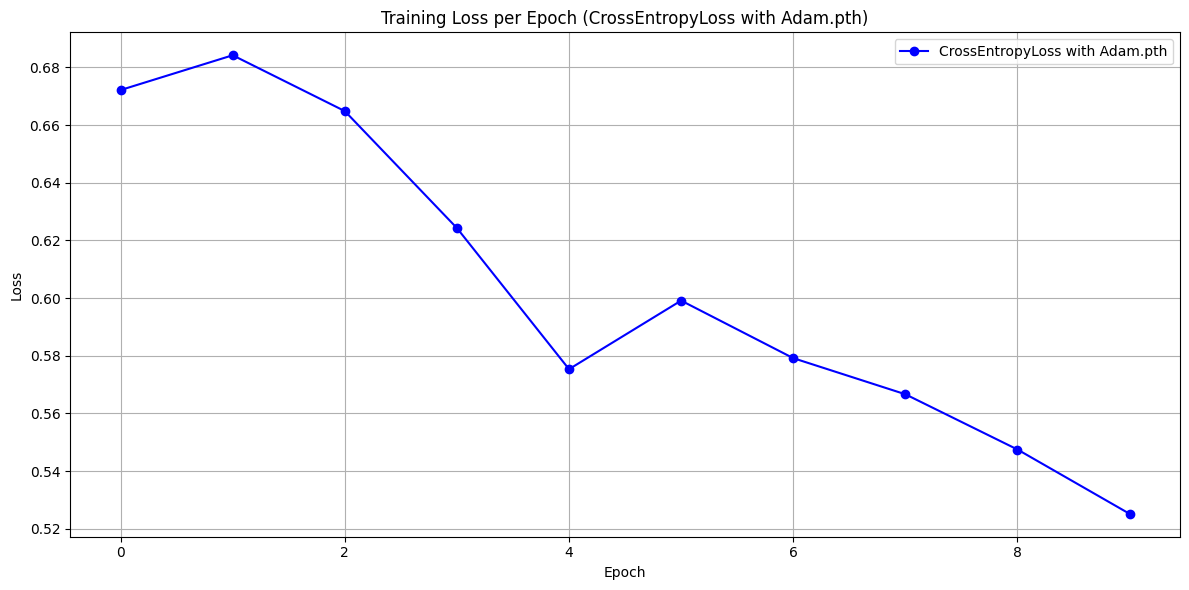

Test Accuracy :  73.15625


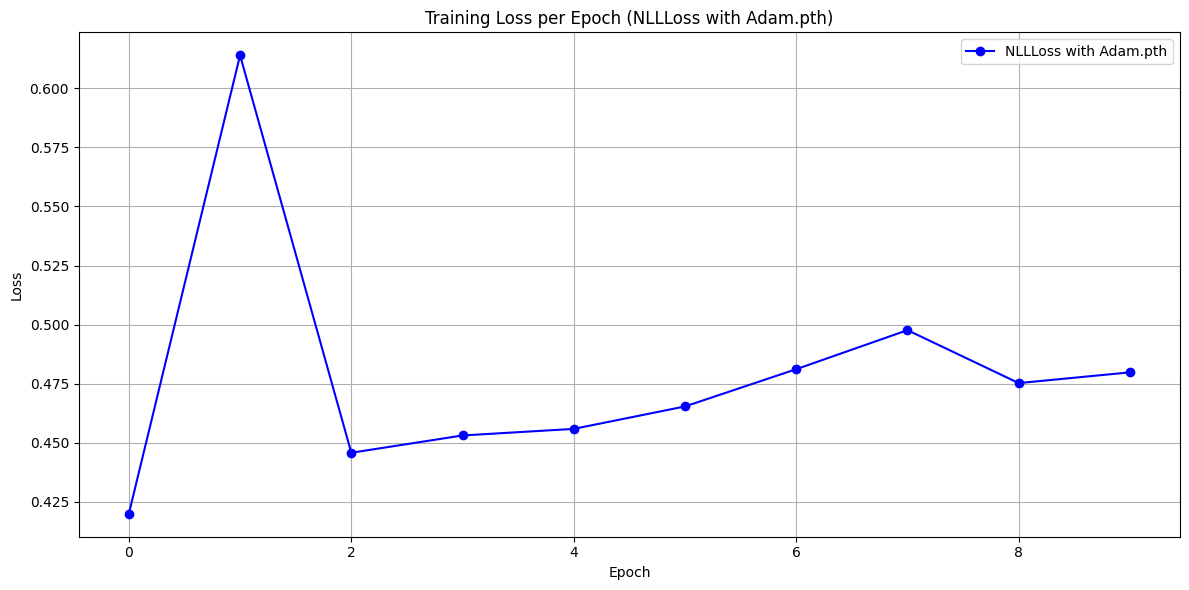

Test Accuracy :  72.5625


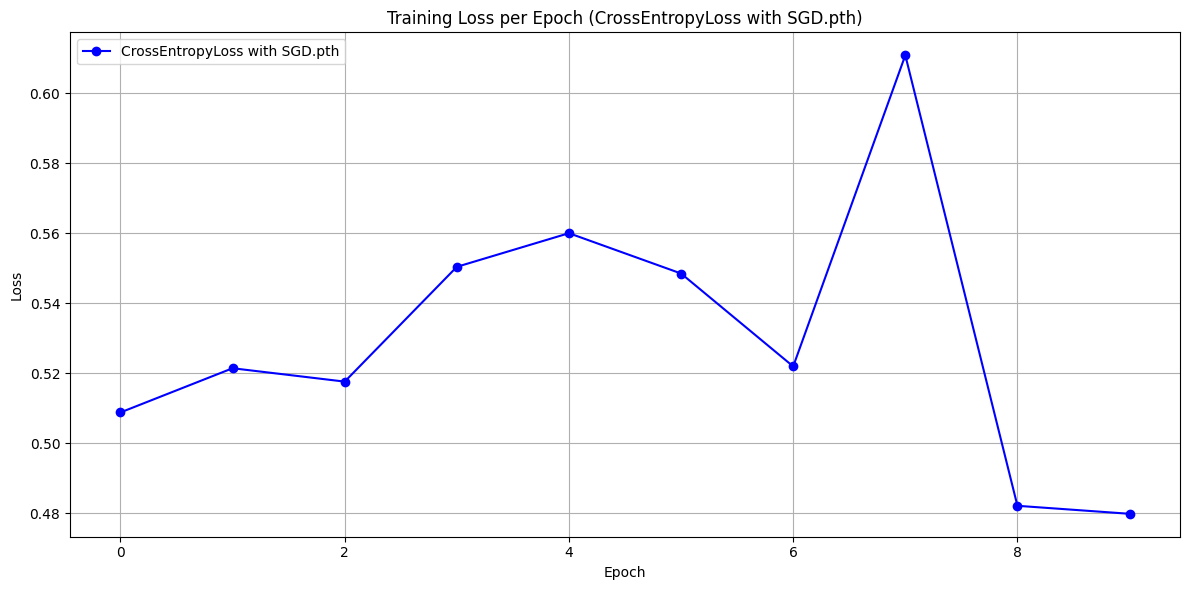

Test Accuracy :  75.4375


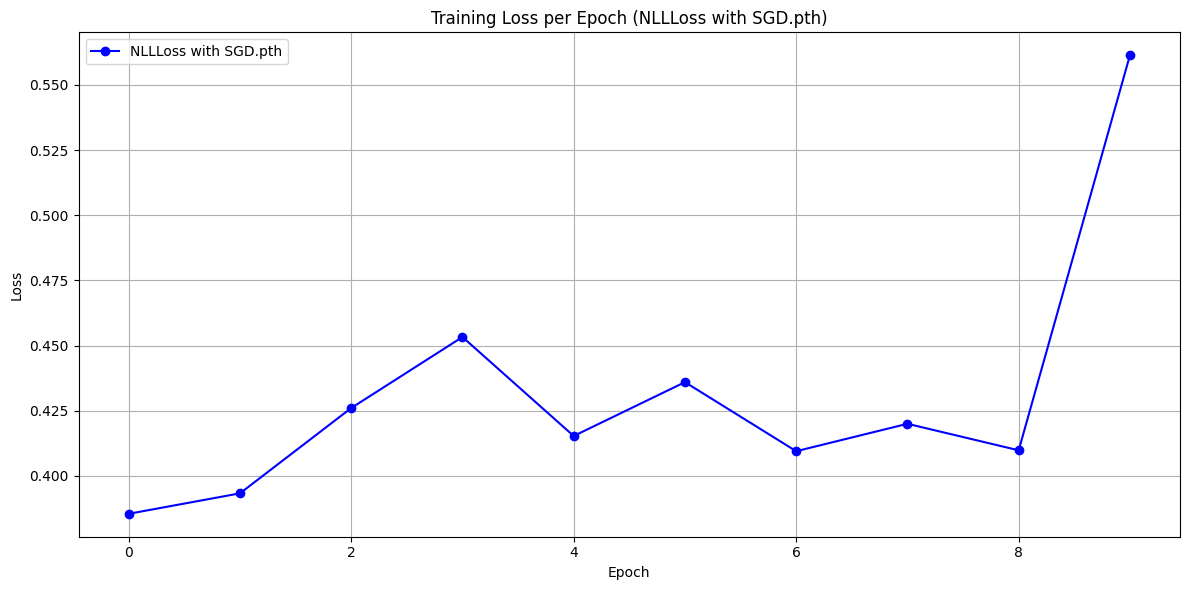

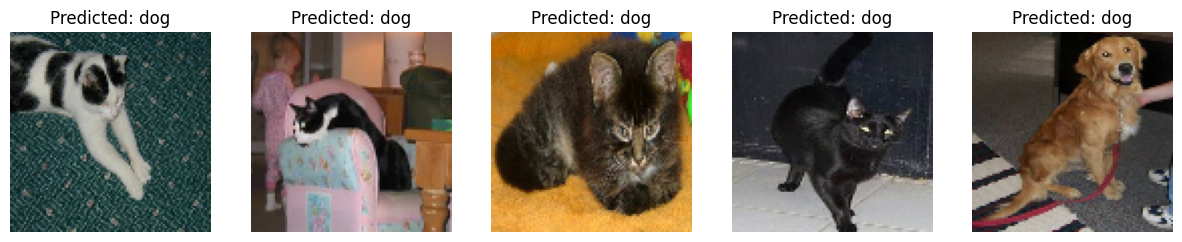

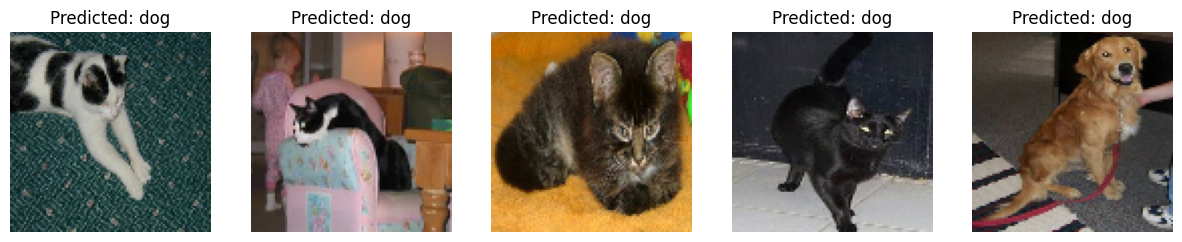

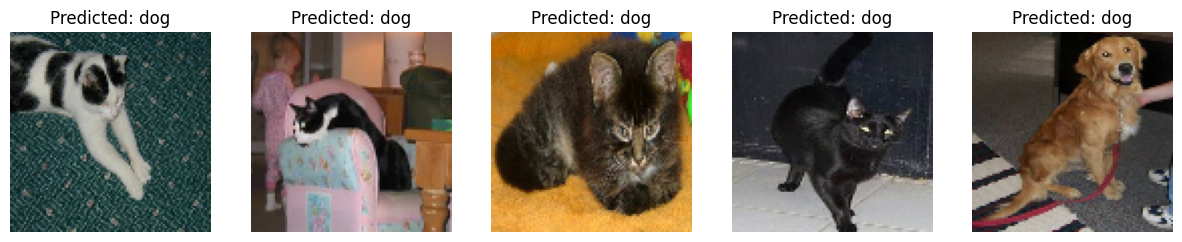

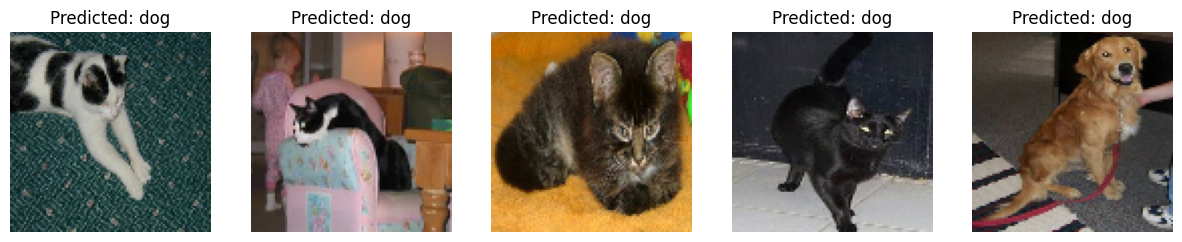

In [10]:
model = Trainer(net, EPOCHS, loss_functions, optimizers, train_loader, test_loader, lr)


PATH = "C:\\work\\CNN cats and dogs\\"
model_path_CrossEntropyLoss_Adam = PATH + "best_model_CrossEntropyLoss_Adam.pth"
model_path_NLLLoss_Adam = PATH + "best_model_NLLLoss_Adam.pth"
model_path_CrossEntropyLoss_SGD = PATH + "best_model_CrossEntropyLoss_SGD.pth"
model_path_NLLLoss_SGD = PATH + "best_model_NLLLoss_SGD.pth"

pred_y = []
test_x = []

for data in test_loader:
    X_test, _ = data
    output = net(X_test)
    _, predicted = torch.max(output.data, 1)
    pred_y.extend(predicted.tolist())  
    test_x.extend(X_test)

model.train()
model.test(model_path_CrossEntropyLoss_Adam)
model.plot_training_loss(model_path_CrossEntropyLoss_Adam)
model.test(model_path_NLLLoss_Adam)
model.plot_training_loss(model_path_NLLLoss_Adam)
model.test(model_path_CrossEntropyLoss_SGD)
model.plot_training_loss(model_path_CrossEntropyLoss_SGD)
model.test(model_path_NLLLoss_SGD)
model.plot_training_loss(model_path_NLLLoss_SGD)
model.display_predictions(model_path_CrossEntropyLoss_Adam, test_x, pred_y)
model.display_predictions(model_path_NLLLoss_Adam, test_x, pred_y)
model.display_predictions(model_path_CrossEntropyLoss_SGD, test_x, pred_y)
model.display_predictions(model_path_NLLLoss_SGD, test_x, pred_y)